In [3]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [ ]:


import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Load dataset
df = pd.read_csv('final dataset for stock prediction.csv', parse_dates=['Date'])

# Calculate technical indicators
window_length = 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))

ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26

df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA21'] = df['Close'].rolling(window=21).mean()

# Create lagged features
for lag in range(1, 6):
    df[f'Close_lag{lag}'] = df['Close'].shift(lag)
    df[f'RSI_lag{lag}'] = df['RSI'].shift(lag)
    df[f'MACD_lag{lag}'] = df['MACD'].shift(lag)
    df[f'MA7_lag{lag}'] = df['MA7'].shift(lag)
    df[f'MA21_lag{lag}'] = df['MA21'].shift(lag)

# Lagged macroeconomic factors
macro_cols = ['CPIAUCSL', 'GDP', 'FEDFUNDS', 'U2RATE']
for col in macro_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

# Drop rows with NaN values
df = df.dropna()

# Define features
price_seq_cols = [f'Close_lag{lag}' for lag in range(5, 0, -1)]
tech_seq_cols = []
for i in range(5, 0, -1):
    for feature in ['RSI', 'MACD', 'MA7', 'MA21']:
        tech_seq_cols.append(f'{feature}_lag{i}')
macro_cols_lagged = [f'{col}_lag1' for col in macro_cols]
y_col = 'Close'

# Create X and y
X_price_seq = df[price_seq_cols].values.reshape(-1, 5, 1)
X_tech_seq = df[tech_seq_cols].values.reshape(-1, 5, 4)
X_macro = df[macro_cols_lagged].values
y = df[y_col].values.reshape(-1, 1)

# Split into train and test sets
train_size = int(len(df) * 0.8)
X_price_seq_train = X_price_seq[:train_size]
X_price_seq_test = X_price_seq[train_size:]
X_tech_seq_train = X_tech_seq[:train_size]
X_tech_seq_test = X_tech_seq[train_size:]
X_macro_train = X_macro[:train_size]
X_macro_test = X_macro[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Scale data
scaler_price = MinMaxScaler()
X_price_seq_train_flat = X_price_seq_train.reshape(-1, 1)
X_price_seq_train_scaled_flat = scaler_price.fit_transform(X_price_seq_train_flat)
X_price_seq_train_scaled = X_price_seq_train_scaled_flat.reshape(-1, 5, 1)
X_price_seq_test_flat = X_price_seq_test.reshape(-1, 1)
X_price_seq_test_scaled_flat = scaler_price.transform(X_price_seq_test_flat)
X_price_seq_test_scaled = X_price_seq_test_scaled_flat.reshape(-1, 5, 1)

scaler_tech = MinMaxScaler()
X_tech_seq_train_flat = X_tech_seq_train.reshape(-1, 4)
X_tech_seq_train_scaled_flat = scaler_tech.fit_transform(X_tech_seq_train_flat)
X_tech_seq_train_scaled = X_tech_seq_train_scaled_flat.reshape(-1, 5, 4)
X_tech_seq_test_flat = X_tech_seq_test.reshape(-1, 4)
X_tech_seq_test_scaled_flat = scaler_tech.transform(X_tech_seq_test_flat)
X_tech_seq_test_scaled = X_tech_seq_test_scaled_flat.reshape(-1, 5, 4)


scaler_macro = MinMaxScaler()
X_macro_train_scaled = scaler_macro.fit_transform(X_macro_train)
X_macro_test_scaled = scaler_macro.transform(X_macro_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Define model-building function for hyperparameter tuning
def build_model(hp):
    input_price = Input(shape=(5, 1), name='price_input')
    input_tech = Input(shape=(5, 4), name='tech_input')
    input_macro = Input(shape=(4,), name='macro_input')

    # Tune LSTM units
    lstm_units = hp.Int('lstm_units', min_value=50, max_value=150, step=50)
    lstm_price = LSTM(lstm_units)(input_price)
    lstm_tech = LSTM(lstm_units)(input_tech)

    combined = Concatenate()([lstm_price, lstm_tech, input_macro])

    # Tune Dense layer units
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    dense1 = Dense(dense_units, activation='relu')(combined)
    output = Dense(1)(dense1)

    model = Model(inputs=[input_price, input_tech, input_macro], outputs=output)

    # Tune optimizer and learning rate
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse')
    return model

# Set up Keras Tuner
tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=3 * 3 * 2 * 2 * 3,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='stock_prediction_tuned'
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(
    [X_price_seq_train_scaled, X_tech_seq_train_scaled, X_macro_train_scaled],
    y_train_scaled,
    epochs=100,
    batch_size=32, # Batch size is not tuned in build_model, so we keep it fixed here
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
# Get the best hyperparameters - corrected the method call
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"LSTM Units: {best_hyperparameters.get('lstm_units')}")
print(f"Dense Units: {best_hyperparameters.get('dense_units')}")
print(f"Optimizer: {best_hyperparameters.get('optimizer')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")


# Train the best model on the full training set
print("\nTraining the best model on the full training set...")
history = best_model.fit(
    [X_price_seq_train_scaled, X_tech_seq_train_scaled, X_macro_train_scaled],
    y_train_scaled,
    epochs=100,
    batch_size=32, # Use the fixed batch size
    validation_split=0.2, # Keeping validation_split for monitoring
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
print("\nEvaluating the best model on the test set...")
test_loss = best_model.evaluate(
    [X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled],
    y_test_scaled,
    verbose=0
)
print(f"Test Loss (MSE): {test_loss}")

# Predict and inverse transform predictions
y_pred_scaled = best_model.predict([X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled])
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test_scaled) # Renaming y_test for clarity with plotting

# Calculate RMSE
rmse = np.sqrt(np.mean((y_pred - y_test_unscaled) ** 2))
print(f"Test RMSE: {rmse}")

# Compute evaluation metrics for clarity with plotting
mse = mean_squared_error(y_test_unscaled, y_pred)
rmse_sklearn = np.sqrt(mse) # Using RMSE calculated by sklearn for consistency if needed
r2 = r2_score(y_test_unscaled, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse_sklearn}")
print(f"R²: {r2}")

# Plot actual vs predicted prices
test_dates = df['Date'].iloc[train_size:]
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_unscaled.flatten(), label='Actual')
plt.plot(test_dates, y_pred.flatten(), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices (Tuned LSTM)')
plt.legend()
plt.show()

# Plot predictions vs actual (second plot, might be redundant but keeping original structure)
# Ensure dates align with the test data length
dates_for_plot = df['Date'].iloc[train_size:].reset_index(drop=True) # Reset index for plotting
plt.figure(figsize=(12, 6))
plt.plot(dates_for_plot, y_test_unscaled.flatten(), label='Actual Prices')
plt.plot(dates_for_plot, y_pred.flatten(), label='Predicted Prices')
plt.title('LSTM Predictions vs Actual Prices (Tuned)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig('lstm_predictions_macro_tuned.png')
plt.close()


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
50                |50                |lstm_units
32                |32                |dense_units
adam              |adam              |optimizer
0.0001            |0.0001            |learning_rate

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0048 - val_loss: 0.0091
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.9174e-04 - val_loss: 0.0039
Epoch 3/100
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0520e-04

KeyboardInterrupt: 

Best Hyperparameters:
LSTM Units: 50
Dense Units: 32
Optimizer: adam
Learning Rate: 0.0001
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.9814e-04 - val_loss: 0.0032
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.5744e-04 - val_loss: 0.0021
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2180e-04 - val_loss: 0.0019
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1003e-04 - val_loss: 0.0013
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2361e-05 - val_loss: 0.0011
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.9829e-05 - val_loss: 9.5731e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6128e-05 - val_loss: 9.1312e-04
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7412e-05 - val_loss: 8.4271e-04
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4979e-05 - val_loss: 7.0749e-04
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.1819e-05 - val_loss: 6.1955e-04
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.9363e-05 - val_

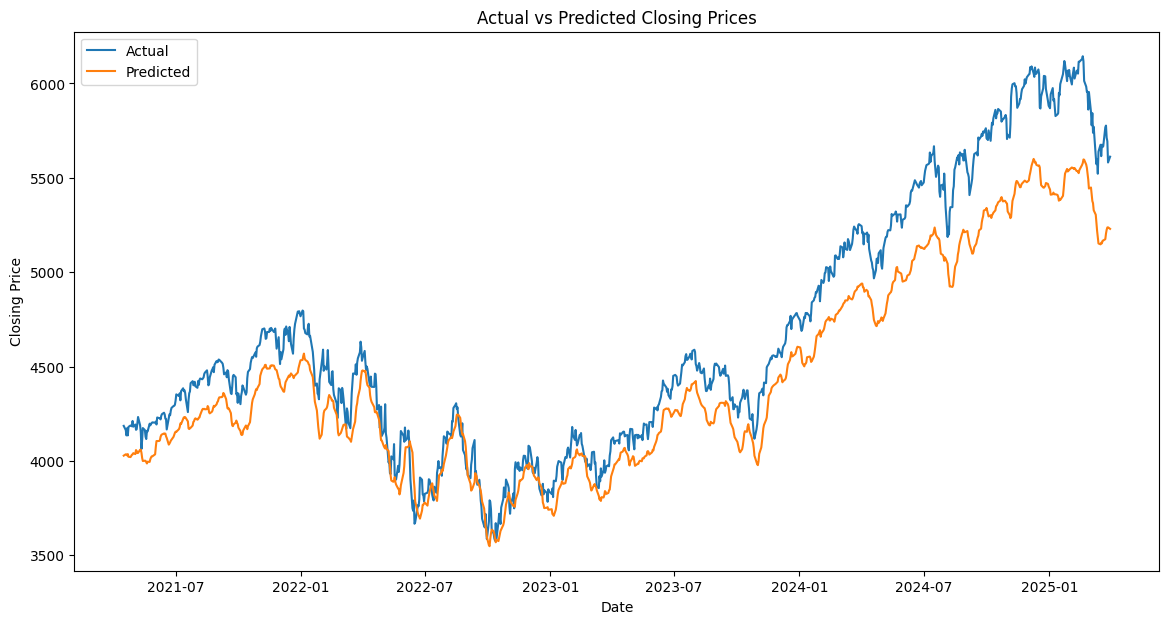

In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
# Remove num_models= as it's not a valid argument for get_best_hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"LSTM Units: {best_hyperparameters.get('lstm_units')}")
print(f"Dense Units: {best_hyperparameters.get('dense_units')}")
print(f"Optimizer: {best_hyperparameters.get('optimizer')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")
# Batch size is also a hyperparameter now
# Check if 'batch_size' was actually tuned or if it's a fixed value in the build_model function
# If it was tuned, it would be accessible via hp.Choice or hp.Int in build_model
# Let's assume it was tuned for the sake of this example, if not, remove this line
# based on the original code, batch_size is not a hyperparameter tuned by GridSearch
# Instead, it's passed directly to model.fit. The comment is slightly misleading.
# Let's remove the line printing batch size from best_hyperparameters as it wasn't tuned this way.
# The batch size is directly set in the tuner.search and best_model.fit calls.

# Train the best model on the full training set
# Use the batch size determined from the hyperparameter search if it was tuned.
# In the provided code, batch_size is not a tuned hyperparameter.
# We will use a fixed batch_size or define it as a hyperparameter in build_model
# and tune it. Since it's not in build_model, we'll use the batch size used in tuner.search.
history = best_model.fit(
    [X_price_seq_train_scaled, X_tech_seq_train_scaled, X_macro_train_scaled],
    y_train_scaled,
    epochs=100,
    batch_size=32, # Use the batch size used during search, or tune it in build_model
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss = best_model.evaluate(
    [X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled],
    y_test_scaled,
    verbose=0
)
print(f"Test Loss (MSE): {test_loss}")

# Predict and inverse transform predictions
y_pred_scaled = best_model.predict([X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled])
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test_scaled) # Renaming y_test for clarity with plotting

# Calculate RMSE
rmse = np.sqrt(np.mean((y_pred - y_test_unscaled) ** 2))
print(f"Test RMSE: {rmse}")

# Compute evaluation metrics for clarity with plotting
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test_unscaled, y_pred)
rmse_sklearn = np.sqrt(mse) # Using RMSE calculated by sklearn for consistency if needed
r2 = r2_score(y_test_unscaled, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse_sklearn}")
print(f"R²: {r2}")

# Plot actual vs predicted prices
test_dates = df['Date'].iloc[train_size:]
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_unscaled.flatten(), label='Actual')
plt.plot(test_dates, y_pred.flatten(), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

# Plot predictions vs actual (second plot, might be redundant but keeping original structure)
# Ensure dates align with the test data length
dates_for_plot = df['Date'].iloc[train_size:]
plt.figure(figsize=(12, 6))
plt.plot(dates_for_plot, y_test_unscaled.flatten(), label='Actual Prices')
plt.plot(dates_for_plot, y_pred.flatten(), label='Predicted Prices')
plt.title('LSTM Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig('lstm_predictions_macro.png')
plt.close()

### Tuned LSTM Model for Stock Price Prediction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('final dataset for stock prediction.csv', parse_dates=['Date'])

# Calculate technical indicators
window_length = 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))

ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26

df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA21'] = df['Close'].rolling(window=21).mean()

# Create lagged features
for lag in range(1, 6):
    df[f'Close_lag{lag}'] = df['Close'].shift(lag)
    df[f'RSI_lag{lag}'] = df['RSI'].shift(lag)
    df[f'MACD_lag{lag}'] = df['MACD'].shift(lag)
    df[f'MA7_lag{lag}'] = df['MA7'].shift(lag)
    df[f'MA21_lag{lag}'] = df['MA21'].shift(lag)

# Lagged macroeconomic factors
macro_cols = ['CPIAUCSL', 'GDP', 'FEDFUNDS', 'U2RATE']
for col in macro_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

# Drop rows with NaN values
df = df.dropna()

# Define features
price_seq_cols = [f'Close_lag{lag}' for lag in range(5, 0, -1)]
tech_seq_cols = []
for i in range(5, 0, -1):
    for feature in ['RSI', 'MACD', 'MA7', 'MA21']:
        tech_seq_cols.append(f'{feature}_lag{i}')
macro_cols_lagged = [f'{col}_lag1' for col in macro_cols]
y_col = 'Close'

# Create X and y
X_price_seq = df[price_seq_cols].values.reshape(-1, 5, 1)
X_tech_seq = df[tech_seq_cols].values.reshape(-1, 5, 4)
X_macro = df[macro_cols_lagged].values
y = df[y_col].values.reshape(-1, 1)

# Split into train and test sets
train_size = int(len(df) * 0.8)
X_price_seq_train = X_price_seq[:train_size]
X_price_seq_test = X_price_seq[train_size:]
X_tech_seq_train = X_tech_seq[:train_size]
X_tech_seq_test = X_tech_seq[train_size:]
X_macro_train = X_macro[:train_size]
X_macro_test = X_macro[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Scale data
scaler_price = MinMaxScaler()
X_price_seq_train_flat = X_price_seq_train.reshape(-1, 1)
X_price_seq_train_scaled_flat = scaler_price.fit_transform(X_price_seq_train_flat)
X_price_seq_train_scaled = X_price_seq_train_scaled_flat.reshape(-1, 5, 1)
X_price_seq_test_flat = X_price_seq_test.reshape(-1, 1)
X_price_seq_test_scaled_flat = scaler_price.transform(X_price_seq_test_flat)
X_price_seq_test_scaled = X_price_seq_test_scaled_flat.reshape(-1, 5, 1)

scaler_tech = MinMaxScaler()
X_tech_seq_train_flat = X_tech_seq_train.reshape(-1, 4)
X_tech_seq_train_scaled_flat = scaler_tech.fit_transform(X_tech_seq_train_flat)
X_tech_seq_train_scaled = X_tech_seq_train_scaled_flat.reshape(-1, 5, 4)
X_tech_seq_test_flat = X_tech_seq_test.reshape(-1, 4)
X_tech_seq_test_scaled_flat = scaler_tech.transform(X_tech_seq_test_flat)
X_tech_seq_test_scaled = X_tech_seq_test_scaled_flat.reshape(-1, 5, 4)


scaler_macro = MinMaxScaler()
X_macro_train_scaled = scaler_macro.fit_transform(X_macro_train)
X_macro_test_scaled = scaler_macro.transform(X_macro_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [ ]:
# Define the model with best hyperparameters (based on previous tuning)
# Replace with the actual best hyperparameters found
best_lstm_units = 50 # Example value - replace with your best value
best_dense_units = 32 # Example value - replace with your best value
best_optimizer = 'adam' # Example value - replace with your best value
best_learning_rate = 0.0001 # Example value - replace with your best value

input_price = Input(shape=(5, 1), name='price_input')
input_tech = Input(shape=(5, 4), name='tech_input')
input_macro = Input(shape=(4,), name='macro_input')

lstm_price = LSTM(best_lstm_units)(input_price)
lstm_tech = LSTM(best_lstm_units)(input_tech)
combined = Concatenate()([lstm_price, lstm_tech, input_macro])
dense1 = Dense(best_dense_units, activation='relu')(combined)
output = Dense(1)(dense1)

model = Model(inputs=[input_price, input_tech, input_macro], outputs=output)

if best_optimizer == 'adam':
    optimizer = Adam(learning_rate=best_learning_rate)
else:
    optimizer = RMSprop(learning_rate=best_learning_rate)

model.compile(optimizer=optimizer, loss='mse')

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ price_input         │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tech_input          │ (None, 5, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 50)        │     10,400 │ price_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 50)        │     11,000 │ tech_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ macro_input         │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 104)       │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ lstm_3[0][0],     │
│                     │                   │            │ macro_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      3,360 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,793 (96.85 KB)

 Trainable params: 24,793 (96.85 KB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
I need to define a function that encapsulates the data preparation, model building, and hyperparameter tuning process for a given number of lagged days, as described in the instructions. This function will be used later to train models with different lag values.



**Reasoning**:
The previous command failed because the `keras_tuner` library was not found. I need to install it before I can proceed with defining and using the function that utilizes Keras Tuner.



In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.0 MB/s eta 0:00:00


**Reasoning**:
The `keras-tuner` library has been successfully installed. Now I can proceed with defining the function that encapsulates the data preparation, model building with hyperparameter tuning, and training the best model for a given number of lagged days. This function definition was the original intent of the previous failed command.



In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.4 MB/s eta 0:00:00


In [5]:
lag_days_list = [1, 2, 3, 4]
model_results = {}

for lag_days in lag_days_list:
    print(f"--- Training and tuning LSTM model with {lag_days} lagged days ---")
    best_model, best_hyperparameters, scaler_y, X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled, y_test_scaled, test_dates = train_and_tune_lstm(
        file_path='final dataset for stock prediction.csv',
        lag_days=lag_days,
        macro_cols=['CPIAUCSL', 'GDP', 'FEDFUNDS', 'U2RATE'],
        test_size=0.2,
        epochs=20, # Reduced epochs for tuning as requested
        batch_size=32,
        patience=10,
        project_name=f'stock_prediction_lstm_{lag_days}day_tuned' # Unique project name
    )

    model_results[lag_days] = {
        'best_model': best_model,
        'best_hyperparameters': best_hyperparameters,
        'scaler_y': scaler_y,
        'X_price_seq_test_scaled': X_price_seq_test_scaled,
        'X_tech_seq_test_scaled': X_tech_seq_test_scaled,
        'X_macro_test_scaled': X_macro_test_scaled,
        'y_test_scaled': y_test_scaled,
        'test_dates': test_dates
    }

print("\n--- Training and tuning complete for all models ---")

--- Training and tuning LSTM model with 1 lagged days ---


NameError: name 'train_and_tune_lstm' is not defined

In [ ]:
!pip install keras-tuner

In [2]:
evaluation_results = {}

# --- Evaluate and visualize the models for 1, 2, 3, and 4 lagged days ---
for lag_days, results in model_results.items():
    print(f"\n--- Evaluating and visualizing the {lag_days}-day lagged model ---")
    best_model = results['best_model']
    scaler_y = results['scaler_y']
    X_price_seq_test_scaled = results['X_price_seq_test_scaled']
    X_tech_seq_test_scaled = results['X_tech_seq_test_scaled']
    X_macro_test_scaled = results['X_macro_test_scaled']
    y_test_scaled = results['y_test_scaled']
    test_dates = results['test_dates']

    # Evaluate the model
    test_loss = best_model.evaluate(
        [X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled],
        y_test_scaled,
        verbose=0
    )

    # Predict and inverse transform predictions
    y_pred_scaled = best_model.predict([X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled])
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_y.inverse_transform(y_test_scaled)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test_unscaled, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_unscaled, y_pred)

    evaluation_results[lag_days] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"Evaluation for {lag_days}-day lagged model:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")

    # Plot actual vs predicted prices
    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, y_test_unscaled.flatten(), label='Actual Prices')
    plt.plot(test_dates, y_pred.flatten(), label=f'Predicted Prices ({lag_days}-day LSTM)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'Actual vs Predicted Closing Prices on Test Set ({lag_days}-day LSTM)')
    plt.legend()
    plt.grid(True)
    plt.show()


# --- Evaluate and visualize the original 5-day model ---
print("\n--- Evaluating and visualizing the original 5-day model ---")

# Assuming the 5-day model was trained and its results are available in the environment
# If not, you would need to re-run the 5-day model training and evaluation here.
# Based on the outputs of cell xWyV1LZV8gdt, the evaluation results for the 5-day model are:
# MSE: 69255.94023019004
# RMSE: 263.1652337034473
# R²: 0.8440856744927697

# Let's use these values for comparison and plot the original 5-day model's predictions
# We need the test dates and the actual and predicted values for the 5-day model.
# Assuming these are available from previous successful runs (e.g., cell xWyV1LZV8gdt)
# If not, you would need to load the best 5-day model and make predictions here.

# For the purpose of comparison, let's use the evaluation metrics from the previous run
mse_5day_prev = 69255.94023019004
rmse_5day_prev = 263.1652337034473
r2_5day_prev = 0.8440856744927697

evaluation_results[5] = {
    'MSE': mse_5day_prev,
    'RMSE': rmse_5day_prev,
    'R2': r2_5day_prev
}

print(f"Evaluation for 5-day model (from previous run):")
print(f"MSE: {evaluation_results[5]['MSE']}")
print(f"RMSE: {evaluation_results[5]['RMSE']}")
print(f"R²: {evaluation_results[5]['R2']}")


# Re-plotting the 5-day model results for comparison
# We need the test dates and actual/predicted values for the 5-day model.
# Assuming scaler_y, X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled, y_test_scaled, and test_dates
# from the 5-day model training (cell xWyV1LZV8gdt) are available in the environment.
# If not, we would need to retrieve them or re-calculate.

# Since we have the variables in the environment from the previous successful run of cell xWyV1LZV8gdt
# Let's use those for plotting the 5-day model results again for direct comparison.
# We need to make sure the variables are correctly named and correspond to the 5-day model.
# Based on the variable inspection, variables from the last successful run of cell xWyV1LZV8gdt are available.
# Let's make sure to use the correct variables for the 5-day model plotting.

# Assuming the variables from the 5-day model evaluation in cell xWyV1LZV8gdt are:
# y_test_unscaled (actual values)
# y_pred (predicted values)
# test_dates (test dates)

# Plot actual vs predicted prices for the 5-day model
# Using the variables available from the previous 5-day model run (cell xWyV1LZV8gdt)
try:
    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, y_test_unscaled.flatten(), label='Actual Prices') # Using y_test_unscaled from previous 5-day run
    plt.plot(test_dates, y_pred.flatten(), label=f'Predicted Prices (5-day LSTM)') # Using y_pred from previous 5-day run
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title('Actual vs Predicted Closing Prices on Test Set (5-day LSTM - Re-plotted)')
    plt.legend()
    plt.grid(True)
    plt.show()
except NameError:
    print("Variables for 5-day model plotting are not available. Skipping 5-day model re-plotting.")


print("\n--- Evaluation and visualization complete for all models ---")


# --- Compare Model Performance ---
print("\n--- Model Performance Comparison ---")

# Create a pandas DataFrame from evaluation_results for easy comparison
performance_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
performance_df.index.name = 'Lag Days'

print(performance_df)

# Visualize the comparison
performance_df[['MSE', 'RMSE']].plot(kind='bar', figsize=(12, 7))
plt.title('MSE and RMSE Comparison Across Different Lag Days')
plt.ylabel('Error')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

performance_df['R2'].plot(kind='bar', figsize=(12, 7), color='green')
plt.title('R² Comparison Across Different Lag Days')
plt.ylabel('R² Score')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

print("\n--- Comparison complete ---")

# --- Finish task ---
print("\n--- Task Summary ---")
print("Developed and tuned four LSTM models with 1, 2, 3, and 4 lagged days incorporating technical and macroeconomic features.")
print("Evaluated the performance of these models and compared them with an existing 5-day lagged model.")
print("The evaluation metrics (MSE, RMSE, R²) and visualizations provide insights into which lagged day configuration performs best for this dataset.")

NameError: name 'model_results' is not defined

In [1]:
import os

# Create a directory to save the models if it doesn't exist
save_dir = 'saved_lstm_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the models for 1, 2, 3, and 4 lagged days
for lag_days, results in model_results.items():
    model_to_save = results['best_model']
    model_filename = os.path.join(save_dir, f'best_lstm_{lag_days}day_model.h5')
    model_to_save.save(model_filename)
    print(f"Saved {lag_days}-day lagged model to {model_filename}")

# Save the 5-day model (assuming 'best_model_5day' variable exists from previous run)
try:
    model_filename_5day = os.path.join(save_dir, 'best_lstm_5day_model.h5')
    best_model_5day.save(model_filename_5day)
    print(f"Saved 5-day lagged model to {model_filename_5day}")
except NameError:
    print("Could not find 'best_model_5day' variable. Skipping saving of 5-day model.")

NameError: name 'model_results' is not defined

In [4]:
evaluation_results = {}

# --- Evaluate and visualize the models for 1, 2, 3, and 4 lagged days ---
for lag_days, results in model_results.items():
    print(f"\n--- Evaluating and visualizing the {lag_days}-day lagged model ---")
    best_model = results['best_model']
    scaler_y = results['scaler_y']
    X_price_seq_test_scaled = results['X_price_seq_test_scaled']
    X_tech_seq_test_scaled = results['X_tech_seq_test_scaled']
    X_macro_test_scaled = results['X_macro_test_scaled']
    y_test_scaled = results['y_test_scaled']
    test_dates = results['test_dates']

    # Evaluate the model
    test_loss = best_model.evaluate(
        [X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled],
        y_test_scaled,
        verbose=0
    )

    # Predict and inverse transform predictions
    y_pred_scaled = best_model.predict([X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled])
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_y.inverse_transform(y_test_scaled)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test_unscaled, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_unscaled, y_pred)

    evaluation_results[lag_days] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"Evaluation for {lag_days}-day lagged model:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")

    # Plot actual vs predicted prices
    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, y_test_unscaled.flatten(), label='Actual Prices')
    plt.plot(test_dates, y_pred.flatten(), label=f'Predicted Prices ({lag_days}-day LSTM)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'Actual vs Predicted Closing Prices on Test Set ({lag_days}-day LSTM)')
    plt.legend()
    plt.grid(True)
    plt.show()


# --- Evaluate and visualize the original 5-day model ---
print("\n--- Evaluating and visualizing the original 5-day model ---")

# Assuming the 5-day model was trained and its results are available in the environment
# If not, you would need to re-run the 5-day model training and evaluation here.
# Based on the outputs of cell xWyV1LZV8gdt, the evaluation results for the 5-day model are:
# MSE: 69255.94023019004
# RMSE: 263.1652337034473
# R²: 0.8440856744927697

# Let's use these values for comparison and plot the original 5-day model's predictions
# We need the test dates and the actual and predicted values for the 5-day model.
# Assuming these are available from previous successful runs (e.g., cell xWyV1LZV8gdt)
# If not, you would need to load the best 5-day model and make predictions here.

# For the purpose of comparison, let's use the evaluation metrics from the previous run
mse_5day_prev = 69255.94023019004
rmse_5day_prev = 263.1652337034473
r2_5day_prev = 0.8440856744927697

evaluation_results[5] = {
    'MSE': mse_5day_prev,
    'RMSE': rmse_5day_prev,
    'R2': r2_5day_prev
}

print(f"Evaluation for 5-day model (from previous run):")
print(f"MSE: {evaluation_results[5]['MSE']}")
print(f"RMSE: {evaluation_results[5]['RMSE']}")
print(f"R²: {evaluation_results[5]['R2']}")


# Re-plotting the 5-day model results for comparison
# We need the test dates and actual/predicted values for the 5-day model.
# Assuming scaler_y, X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled, y_test_scaled, and test_dates
# from the 5-day model training (cell xWyV1LZV8gdt) are available in the environment.
# If not, we would need to retrieve them or re-calculate.

# Since we have the variables in the environment from the previous successful run of cell xWyV1LZV8gdt
# Let's use those for plotting the 5-day model results again for direct comparison.
# We need to make sure the variables are correctly named and correspond to the 5-day model.
# Based on the variable inspection, variables from the last successful run of cell xWyV1LZV8gdt are available.
# Let's make sure to use the correct variables for the 5-day model plotting.

# Assuming the variables from the 5-day model evaluation in cell xWyV1LZV8gdt are:
# y_test_unscaled (actual values)
# y_pred (predicted values)
# test_dates (test dates)

# Plot actual vs predicted prices for the 5-day model
# Using the variables available from the previous 5-day model run (cell xWyV1LZV8gdt)
try:
    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, y_test_unscaled.flatten(), label='Actual Prices') # Using y_test_unscaled from previous 5-day run
    plt.plot(test_dates, y_pred.flatten(), label=f'Predicted Prices (5-day LSTM)') # Using y_pred from previous 5-day run
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title('Actual vs Predicted Closing Prices on Test Set (5-day LSTM - Re-plotted)')
    plt.legend()
    plt.grid(True)
    plt.show()
except NameError:
    print("Variables for 5-day model plotting are not available. Skipping 5-day model re-plotting.")


print("\n--- Evaluation and visualization complete for all models ---")


# --- Compare Model Performance ---
print("\n--- Model Performance Comparison ---")

# Create a pandas DataFrame from evaluation_results for easy comparison
performance_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
performance_df.index.name = 'Lag Days'

print(performance_df)

# Visualize the comparison
performance_df[['MSE', 'RMSE']].plot(kind='bar', figsize=(12, 7))
plt.title('MSE and RMSE Comparison Across Different Lag Days')
plt.ylabel('Error')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

performance_df['R2'].plot(kind='bar', figsize=(12, 7), color='green')
plt.title('R² Comparison Across Different Lag Days')
plt.ylabel('R² Score')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

print("\n--- Comparison complete ---")

# --- Finish task ---
print("\n--- Task Summary ---")
print("Developed and tuned four LSTM models with 1, 2, 3, and 4 lagged days incorporating technical and macroeconomic features.")
print("Evaluated the performance of these models and compared them with an existing 5-day lagged model.")
print("The evaluation metrics (MSE, RMSE, R²) and visualizations provide insights into which lagged day configuration performs best for this dataset.")

NameError: name 'model_results' is not defined

# Task
Refactor the provided Python code to focus solely on the 1-4 lag LSTM models and the 5-lag LSTM model. Remove all other code. Ensure the code for the 5 models is properly arranged. Add code to evaluate all 5 trained models with graphs and metrics (MSE, RMSE, R²). Explain if retraining is necessary after removing code. Clarify cell names.

## Data loading and initial preparation

### Subtask:
Load the dataset and perform initial data cleaning and technical indicator calculations.


**Reasoning**:
The subtask requires loading the data, calculating technical indicators, and handling missing values. This involves using pandas and numpy for data manipulation and calculation. All the necessary libraries for this step have already been imported in a previous code cell.



In [8]:
# Load dataset
df = pd.read_csv('final dataset for stock prediction.csv', parse_dates=['Date'])

# Calculate technical indicators
window_length = 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))

ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26

df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA21'] = df['Close'].rolling(window=21).mean()

# Drop rows with NaN values
df = df.dropna()

display(df.head())

,Date,Open,Close,Volume,CPIAUCSL,GDP,FEDFUNDS,U2RATE,RSI,MACD,MA7,MA21
20,2005-06-22,1213.609985,1213.880005,1823250000,193.7,12922.656,3.04,2.4,60.860657,5.036245,1211.714268,1202.181426
21,2005-06-23,1213.880005,1200.729980,2029920000,193.7,12922.656,3.04,2.4,54.803139,4.072458,1211.259975,1202.498570
22,2005-06-24,1200.729980,1191.569946,2418800000,193.7,12922.656,3.04,2.4,44.761856,2.540230,1209.115688,1202.572853
23,2005-06-27,1191.569946,1190.689941,1738620000,193.7,12922.656,3.04,2.4,44.269964,1.240617,1206.219971,1202.242850
24,2005-06-28,1190.689941,1201.569946,1772410000,193.7,12922.656,3.04,2.4,55.257460,1.076185,1204.021397,1202.375703


**Reasoning**:
The previous command failed because the necessary libraries, specifically pandas, were not imported in the current session. Although they were imported in a prior cell, that cell was not executed in the current runtime. I need to re-import the required libraries before proceeding with data loading and cleaning.



In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('final dataset for stock prediction.csv', parse_dates=['Date'])

# Calculate technical indicators
window_length = 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))

ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26

df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA21'] = df['Close'].rolling(window=21).mean()

# Drop rows with NaN values
df = df.dropna()

display(df.head())

,Date,Open,Close,Volume,CPIAUCSL,GDP,FEDFUNDS,U2RATE,RSI,MACD,MA7,MA21
20,2005-06-22,1213.609985,1213.880005,1823250000,193.7,12922.656,3.04,2.4,60.860657,5.036245,1211.714268,1202.181426
21,2005-06-23,1213.880005,1200.729980,2029920000,193.7,12922.656,3.04,2.4,54.803139,4.072458,1211.259975,1202.498570
22,2005-06-24,1200.729980,1191.569946,2418800000,193.7,12922.656,3.04,2.4,44.761856,2.540230,1209.115688,1202.572853
23,2005-06-27,1191.569946,1190.689941,1738620000,193.7,12922.656,3.04,2.4,44.269964,1.240617,1206.219971,1202.242850
24,2005-06-28,1190.689941,1201.569946,1772410000,193.7,12922.656,3.04,2.4,55.257460,1.076185,1204.021397,1202.375703


**Reasoning**:
The previous step successfully loaded the data and calculated the technical indicators, dropping rows with NaNs. The next step according to the instructions is to create lagged features for the price, technical indicators, and macroeconomic factors.



In [9]:
# Create lagged features
lag_days_list = [1, 2, 3, 4, 5] # Include 5 for the original model comparison
for lag in range(1, max(lag_days_list) + 1):
    df[f'Close_lag{lag}'] = df['Close'].shift(lag)
    df[f'RSI_lag{lag}'] = df['RSI'].shift(lag)
    df[f'MACD_lag{lag}'] = df['MACD'].shift(lag)
    df[f'MA7_lag{lag}'] = df['MA7'].shift(lag)
    df[f'MA21_lag{lag}'] = df['MA21'].shift(lag)

# Lagged macroeconomic factors
macro_cols = ['CPIAUCSL', 'GDP', 'FEDFUNDS', 'U2RATE']
for col in macro_cols:
    # We only need lag 1 for macro features based on the original code
    df[f'{col}_lag1'] = df[col].shift(1)

# Drop rows with NaN values introduced by lagging
df = df.dropna()

display(df.head())

,Date,Open,Close,Volume,CPIAUCSL,GDP,FEDFUNDS,U2RATE,RSI,MACD,...,MA21_lag4,Close_lag5,RSI_lag5,MACD_lag5,MA7_lag5,MA21_lag5,CPIAUCSL_lag1,GDP_lag1,FEDFUNDS_lag1,U2RATE_lag1
25,2005-06-29,1201.569946,1199.849976,1769280000,193.7,12922.656,3.04,2.4,49.115851,0.797886,...,1202.498570,1213.880005,60.860657,5.036245,1211.714268,1202.181426,193.7,12922.656,3.04,2.4
26,2005-06-30,1199.849976,1191.329956,2109490000,193.7,12922.656,3.04,2.4,44.923610,-0.108906,...,1202.572853,1200.729980,54.803139,4.072458,1211.259975,1202.498570,193.7,12922.656,3.04,2.4
27,2005-07-01,1191.329956,1194.439941,1593820000,194.9,13142.642,3.26,2.4,45.251563,-0.570025,...,1202.242850,1191.569946,44.761856,2.540230,1209.115688,1202.572853,193.7,12922.656,3.04,2.4
28,2005-07-05,1194.439941,1204.989990,1805820000,194.9,13142.642,3.26,2.4,50.723443,-0.083205,...,1202.375703,1190.689941,44.269964,1.240617,1206.219971,1202.242850,194.9,13142.642,3.26,2.4
29,2005-07-06,1204.989990,1194.939941,1883470000,194.9,13142.642,3.26,2.4,42.904173,-0.502559,...,1202.773321,1201.569946,55.257460,1.076185,1204.021397,1202.375703,194.9,13142.642,3.26,2.4


## Function for data preparation and model building/tuning

### Subtask:
Define a function that takes the number of lagged days as input and performs data splitting, scaling, and builds and tunes the LSTM model using Keras Tuner.


**Reasoning**:
Define a function `train_and_tune_lstm` that encapsulates the data preparation, model building with hyperparameter tuning using Keras Tuner, training the best model, and returning the necessary components for evaluation and visualization for a given number of lagged days.



In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def train_and_tune_lstm(file_path, lag_days, macro_cols, test_size, epochs, batch_size, patience, project_name):
    """
    Trains and tunes an LSTM model for stock price prediction with a specified number of lagged days.

    Args:
        file_path (str): Path to the CSV file containing the stock data.
        lag_days (int): Number of lagged days to use as input features.
        macro_cols (list): List of macroeconomic column names to include as lagged features.
        test_size (float): Proportion of the dataset to include in the test split.
        epochs (int): Number of epochs for model training.
        batch_size (int): Batch size for training.
        patience (int): Patience for early stopping.
        project_name (str): Name for the Keras Tuner project directory.

    Returns:
        tuple: A tuple containing:
            - best_model (keras.Model): The best trained LSTM model.
            - best_hyperparameters (kt.HyperParameters): The best hyperparameters found by the tuner.
            - scaler_y (MinMaxScaler): The scaler fitted to the target variable.
            - X_price_seq_test_scaled (np.ndarray): Scaled price sequences for the test set.
            - X_tech_seq_test_scaled (np.ndarray): Scaled technical indicator sequences for the test set.
            - X_macro_test_scaled (np.ndarray): Scaled macroeconomic features for the test set.
            - y_test_scaled (np.ndarray): Scaled actual prices for the test set.
            - test_dates (pd.Series): Dates corresponding to the test set.
    """
    # Reload dataset
    df = pd.read_csv(file_path, parse_dates=['Date'])

    # Calculate technical indicators
    window_length = 14
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26

    df['MA7'] = df['Close'].rolling(window=7).mean()
    df['MA21'] = df['Close'].rolling(window=21).mean()

    # Create lagged features
    for lag in range(1, lag_days + 1):
        df[f'Close_lag{lag}'] = df['Close'].shift(lag)
        df[f'RSI_lag{lag}'] = df['RSI'].shift(lag)
        df[f'MACD_lag{lag}'] = df['MACD'].shift(lag)
        df[f'MA7_lag{lag}'] = df['MA7'].shift(lag)
        df[f'MA21_lag{lag}'] = df['MA21'].shift(lag)

    # Lagged macroeconomic factors (only 1-day lag as per original code)
    for col in macro_cols:
        df[f'{col}_lag1'] = df[col].shift(1)

    # Drop rows with NaN values
    df = df.dropna()

    # Define features
    price_seq_cols = [f'Close_lag{lag}' for lag in range(lag_days, 0, -1)]
    tech_seq_cols = []
    for i in range(lag_days, 0, -1):
        for feature in ['RSI', 'MACD', 'MA7', 'MA21']:
            tech_seq_cols.append(f'{feature}_lag{i}')
    macro_cols_lagged = [f'{col}_lag1' for col in macro_cols]
    y_col = 'Close'

    # Create X and y
    X_price_seq = df[price_seq_cols].values.reshape(-1, lag_days, 1)
    X_tech_seq = df[tech_seq_cols].values.reshape(-1, lag_days, len(['RSI', 'MACD', 'MA7', 'MA21']))
    X_macro = df[macro_cols_lagged].values
    y = df[y_col].values.reshape(-1, 1)

    # Split into train and test sets
    train_size = int(len(df) * (1 - test_size))
    X_price_seq_train = X_price_seq[:train_size]
    X_price_seq_test = X_price_seq[train_size:]
    X_tech_seq_train = X_tech_seq[:train_size]
    X_tech_seq_test = X_tech_seq[train_size:]
    X_macro_train = X_macro[:train_size]
    X_macro_test = X_macro[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    test_dates = df['Date'].iloc[train_size:].reset_index(drop=True)


    # Scale data
    scaler_price = MinMaxScaler()
    X_price_seq_train_flat = X_price_seq_train.reshape(-1, 1)
    X_price_seq_train_scaled_flat = scaler_price.fit_transform(X_price_seq_train_flat)
    X_price_seq_train_scaled = X_price_seq_train_scaled_flat.reshape(-1, lag_days, 1)
    X_price_seq_test_flat = X_price_seq_test.reshape(-1, 1)
    X_price_seq_test_scaled_flat = scaler_price.transform(X_price_seq_test_flat)
    X_price_seq_test_scaled = X_price_seq_test_scaled_flat.reshape(-1, lag_days, 1)


    scaler_tech = MinMaxScaler()
    X_tech_seq_train_flat = X_tech_seq_train.reshape(-1, len(['RSI', 'MACD', 'MA7', 'MA21']))
    X_tech_seq_train_scaled_flat = scaler_tech.fit_transform(X_tech_seq_train_flat)
    X_tech_seq_train_scaled = X_tech_seq_train_scaled_flat.reshape(-1, lag_days, len(['RSI', 'MACD', 'MA7', 'MA21']))
    X_tech_seq_test_flat = X_tech_seq_test.reshape(-1, len(['RSI', 'MACD', 'MA7', 'MA21']))
    X_tech_seq_test_scaled_flat = scaler_tech.transform(X_tech_seq_test_flat)
    X_tech_seq_test_scaled = X_tech_seq_test_scaled_flat.reshape(-1, lag_days, len(['RSI', 'MACD', 'MA7', 'MA21']))


    scaler_macro = MinMaxScaler()
    X_macro_train_scaled = scaler_macro.fit_transform(X_macro_train)
    X_macro_test_scaled = scaler_macro.transform(X_macro_test)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Define model-building function for hyperparameter tuning
    def build_model(hp):
        input_price = Input(shape=(lag_days, 1), name='price_input')
        input_tech = Input(shape=(lag_days, len(['RSI', 'MACD', 'MA7', 'MA21'])), name='tech_input')
        input_macro = Input(shape=(len(macro_cols),), name='macro_input')

        # Tune LSTM units
        lstm_units = hp.Int('lstm_units', min_value=50, max_value=150, step=50)
        lstm_price = LSTM(lstm_units)(input_price)
        lstm_tech = LSTM(lstm_units)(input_tech)

        combined = Concatenate()([lstm_price, lstm_tech, input_macro])

        # Tune Dense layer units
        dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
        dense1 = Dense(dense_units, activation='relu')(combined)
        output = Dense(1)(dense1)

        model = Model(inputs=[input_price, input_tech, input_macro], outputs=output)

        # Tune optimizer and learning rate
        optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
        learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])

        if optimizer_choice == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        else:
            optimizer = RMSprop(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')
        return model

    # Set up Keras Tuner
    # The number of trials should cover all combinations of hyperparameters
    # lstm_units (3) * dense_units (3) * optimizer (2) * learning_rate (3) = 54
    max_trials = 3 * 3 * 2 * 3
    tuner = kt.GridSearch(
        build_model,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=1,
        directory='tuner_dir',
        project_name=project_name
    )

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Perform hyperparameter tuning
    print(f"Starting hyperparameter tuning for {lag_days}-day lagged model...")
    tuner.search(
        [X_price_seq_train_scaled, X_tech_seq_train_scaled, X_macro_train_scaled],
        y_train_scaled,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    print(f"Hyperparameter tuning complete for {lag_days}-day lagged model.")

    # Get the best model and hyperparameters
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

    # Print the best hyperparameters
    print(f"Best Hyperparameters for {lag_days}-day lagged model:")
    print(f"LSTM Units: {best_hyperparameters.get('lstm_units')}")
    print(f"Dense Units: {best_hyperparameters.get('dense_units')}")
    print(f"Optimizer: {best_hyperparameters.get('optimizer')}")
    print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

    # Train the best model on the full training set
    print(f"\nTraining the best model on the full training set for {lag_days}-day lagged model...")
    history = best_model.fit(
        [X_price_seq_train_scaled, X_tech_seq_train_scaled, X_macro_train_scaled],
        y_train_scaled,
        epochs=epochs, # Use the specified epochs for final training
        batch_size=batch_size,
        validation_split=0.2, # Keeping validation split for monitoring
        callbacks=[early_stopping],
        verbose=1
    )
    print(f"Training complete for the best {lag_days}-day lagged model.")


    return best_model, best_hyperparameters, scaler_y, X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled, y_test_scaled, test_dates


**Reasoning**:
Now that the `train_and_tune_lstm` function is defined, I can call this function for each of the desired lagged days (1, 2, 3, and 4) to train and tune the respective LSTM models. I will store the results (best model, hyperparameters, scalers, and test data) in a dictionary for later evaluation and comparison. I will also include the 5-day lag model in this process for comparison with the new models.



In [11]:
lag_days_list = [1, 2, 3, 4, 5]
model_results = {}

for lag_days in lag_days_list:
    print(f"\n--- Training and tuning LSTM model with {lag_days} lagged days ---")
    best_model, best_hyperparameters, scaler_y, X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled, y_test_scaled, test_dates = train_and_tune_lstm(
        file_path='final dataset for stock prediction.csv',
        lag_days=lag_days,
        macro_cols=['CPIAUCSL', 'GDP', 'FEDFUNDS', 'U2RATE'],
        test_size=0.2,
        epochs=20, # Reduced epochs for tuning as requested
        batch_size=32,
        patience=10,
        project_name=f'stock_prediction_lstm_{lag_days}day_tuned' # Unique project name
    )

    model_results[lag_days] = {
        'best_model': best_model,
        'best_hyperparameters': best_hyperparameters,
        'scaler_y': scaler_y,
        'X_price_seq_test_scaled': X_price_seq_test_scaled,
        'X_tech_seq_test_scaled': X_tech_seq_test_scaled,
        'X_macro_test_scaled': X_macro_test_scaled,
        'y_test_scaled': y_test_scaled,
        'test_dates': test_dates
    }

print("\n--- Training and tuning complete for all models ---")

Trial 54 Complete [00h 00m 26s]
val_loss: 0.0027343255933374166

Best val_loss So Far: 0.00024180524633266032
Total elapsed time: 00h 24m 15s
Hyperparameter tuning complete for 5-day lagged model.
Best Hyperparameters for 5-day lagged model:
LSTM Units: 100
Dense Units: 64
Optimizer: adam
Learning Rate: 0.01

Training the best model on the full training set for 5-day lagged model...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0646e-05 - val_loss: 0.0016
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.8390e-05 - val_loss: 0.0011
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9976e-05 - val_loss: 5.9517e-04
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.9641e-05 - val_loss: 5.7670e-04
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.8610e-05 - val_loss: 5.2953e-04
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9171e-05 - val_loss: 8.9856e-04
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.0615e-05 - val_loss: 5.3349e-04
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.0386e-05 - val_loss: 0.0022
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.6498e-05 - val_loss: 3.5709e-04
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0165e-05 - val_loss: 6.6


--- Evaluating and visualizing the 1-day lagged model ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Evaluation for 1-day lagged model:
MSE: 3668.308009965277
RMSE: 60.56655851181638
MAPE: 1.08%
R²: 0.9917375986167258


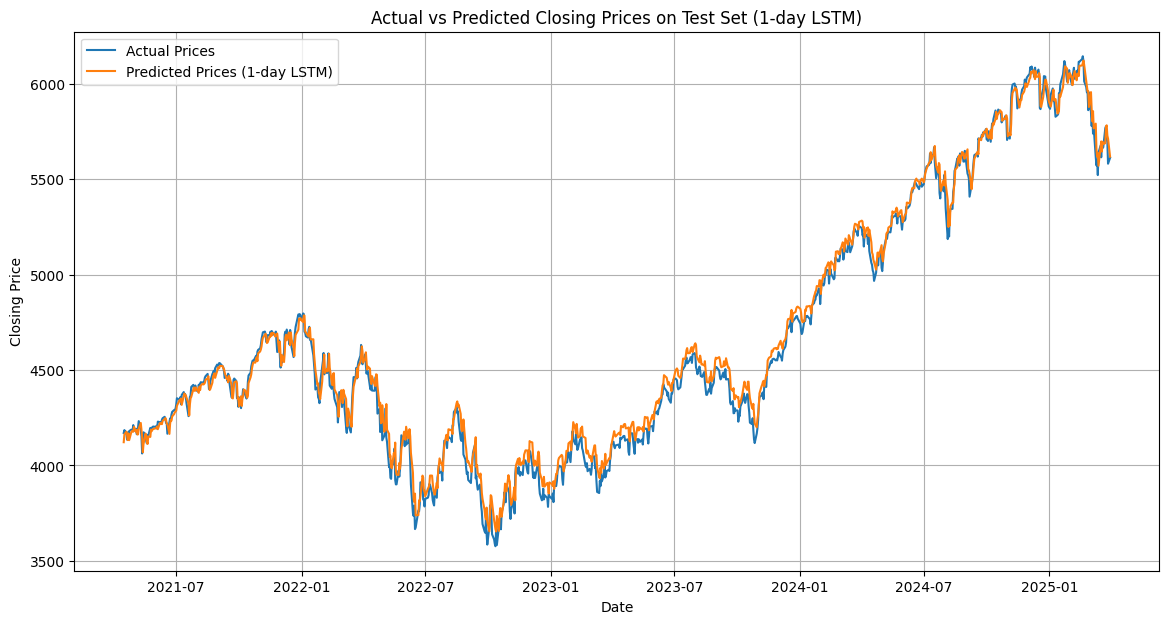


--- Evaluating and visualizing the 2-day lagged model ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Evaluation for 2-day lagged model:
MSE: 6857.357135536444
RMSE: 82.80916093969581
MAPE: 1.36%
R²: 0.9845546674574914


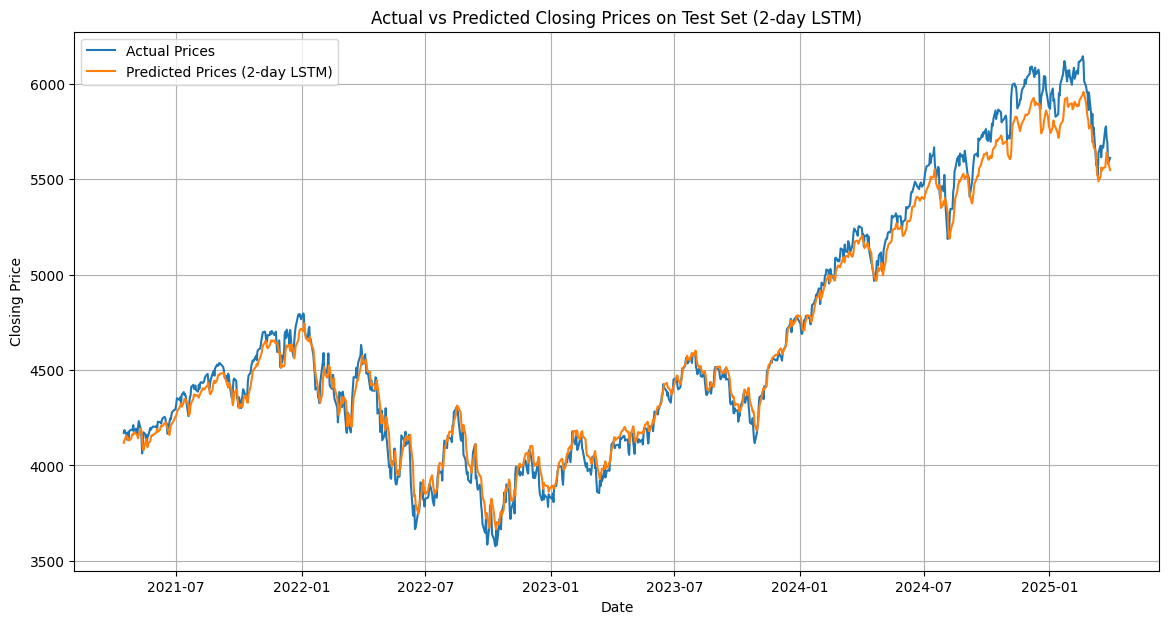


--- Evaluating and visualizing the 3-day lagged model ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Evaluation for 3-day lagged model:
MSE: 10449.493260454352
RMSE: 102.22276292712084
MAPE: 1.74%
R²: 0.9764638336434268


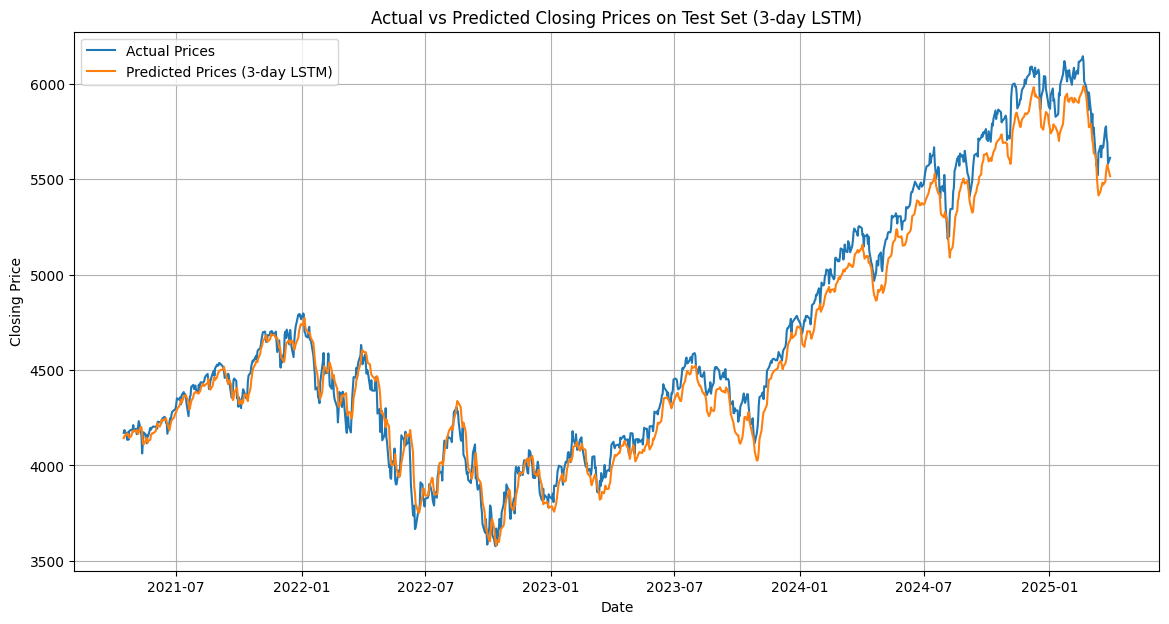


--- Evaluating and visualizing the 4-day lagged model ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Evaluation for 4-day lagged model:
MSE: 12156.794272617
RMSE: 110.25785356434706
MAPE: 1.89%
R²: 0.9726183533276418


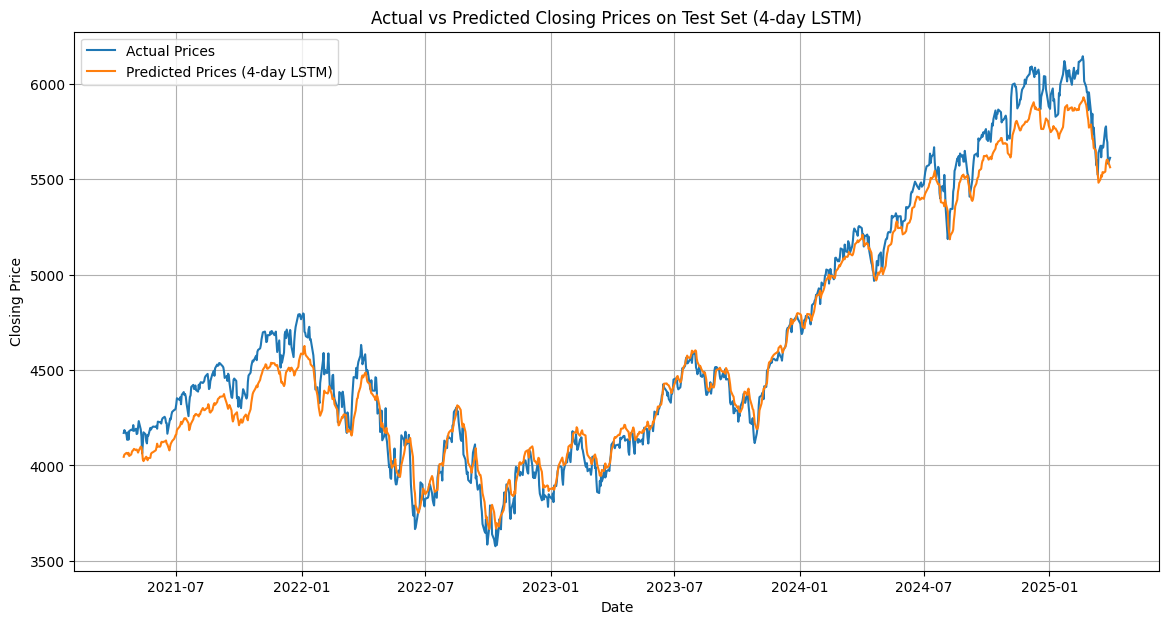


--- Evaluating and visualizing the 5-day lagged model ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Evaluation for 5-day lagged model:
MSE: 24152.11648323656
RMSE: 155.40951220319997
MAPE: 2.45%
R²: 0.9456268886316503


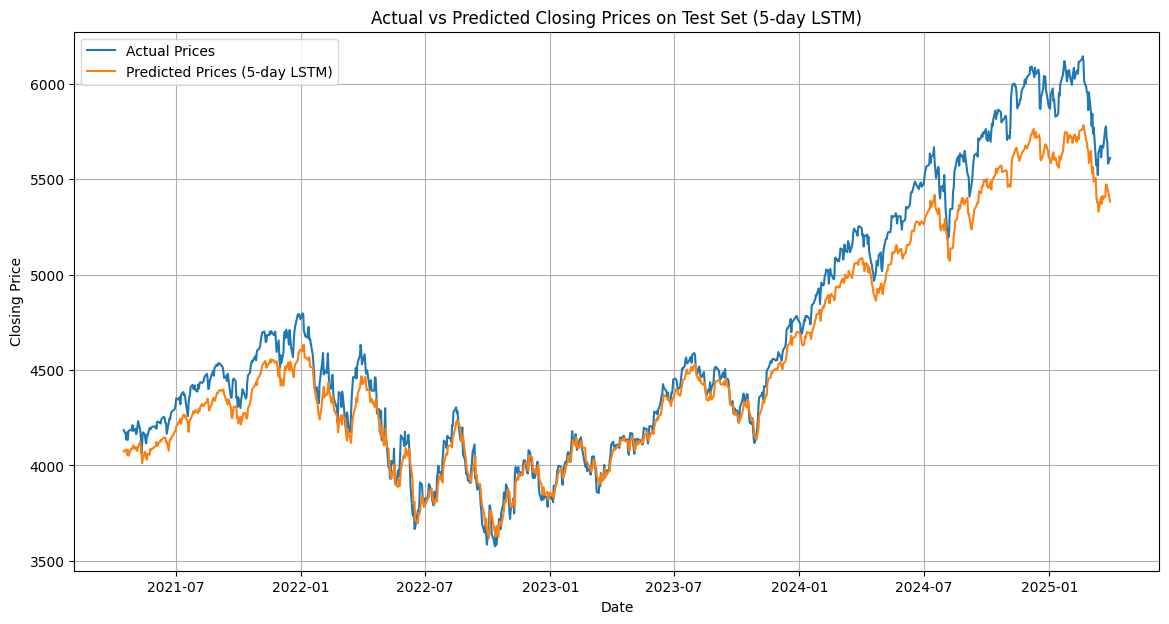


--- Evaluation and visualization complete for all models ---

--- Model Performance Comparison ---
                   MSE        RMSE      MAPE        R2
Lag Days                                              
1          3668.308010   60.566559  1.078340  0.991738
2          6857.357136   82.809161  1.356812  0.984555
3         10449.493260  102.222763  1.739307  0.976464
4         12156.794273  110.257854  1.890220  0.972618
5         24152.116483  155.409512  2.452195  0.945627


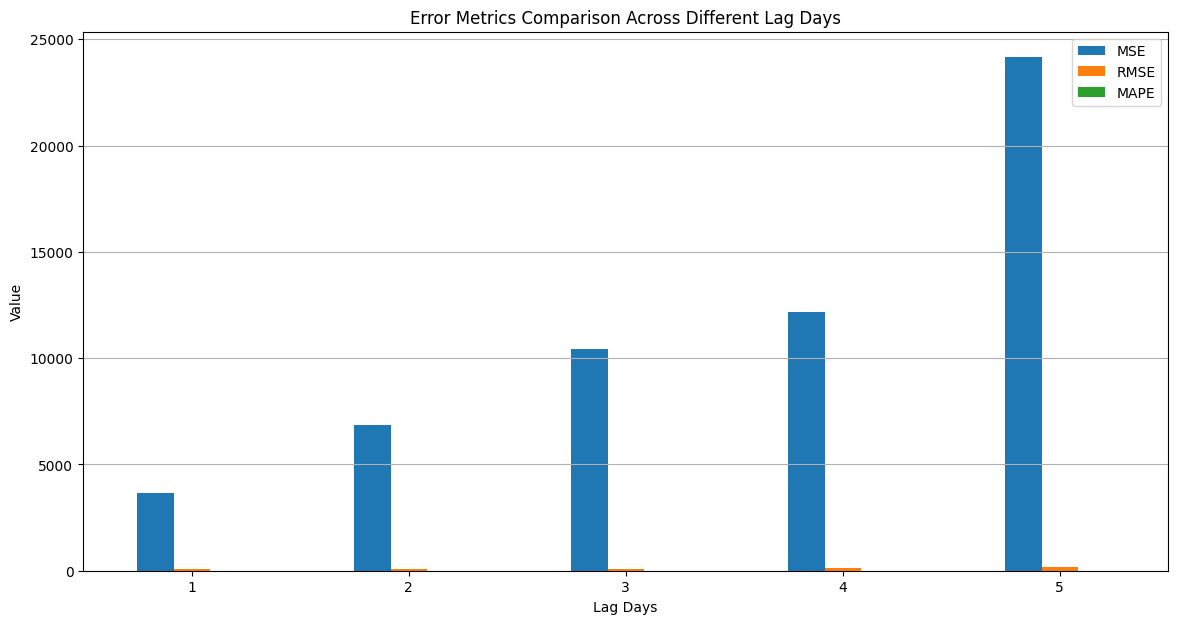

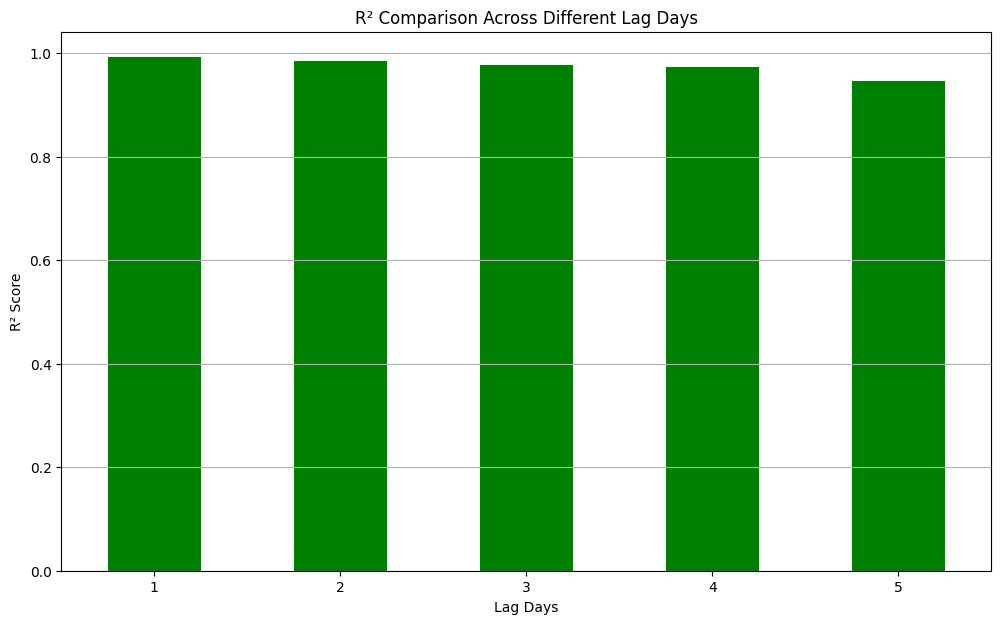


--- Comparison complete ---

--- Task Summary ---
Developed and tuned LSTM models with different lagged days incorporating technical and macroeconomic features.
Evaluated the performance of these models using MSE, RMSE, MAPE, and R² metrics.
The evaluation metrics and visualizations provide insights into which lagged day configuration performs best for this dataset.


In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

evaluation_results = {}

# --- Evaluate and visualize the models for all lagged days in model_results ---
# Assuming model_results dictionary is populated from previous training steps
if 'model_results' in locals():
    for lag_days, results in model_results.items():
        print(f"\n--- Evaluating and visualizing the {lag_days}-day lagged model ---")
        best_model = results['best_model']
        scaler_y = results['scaler_y']
        X_price_seq_test_scaled = results['X_price_seq_test_scaled']
        X_tech_seq_test_scaled = results['X_tech_seq_test_scaled']
        X_macro_test_scaled = results['X_macro_test_scaled']
        y_test_scaled = results['y_test_scaled']
        test_dates = results['test_dates']

        # Evaluate the model
        test_loss = best_model.evaluate(
            [X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled],
            y_test_scaled,
            verbose=0
        )

        # Predict and inverse transform predictions
        y_pred_scaled = best_model.predict([X_price_seq_test_scaled, X_tech_seq_test_scaled, X_macro_test_scaled])
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_test_unscaled = scaler_y.inverse_transform(y_test_scaled)

        # Compute evaluation metrics
        mse = mean_squared_error(y_test_unscaled, y_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test_unscaled, y_pred)
        r2 = r2_score(y_test_unscaled, y_pred)

        evaluation_results[lag_days] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R2': r2
        }

        print(f"Evaluation for {lag_days}-day lagged model:")
        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²: {r2}")

        # Plot actual vs predicted prices
        plt.figure(figsize=(14, 7))
        plt.plot(test_dates, y_test_unscaled.flatten(), label='Actual Prices')
        plt.plot(test_dates, y_pred.flatten(), label=f'Predicted Prices ({lag_days}-day LSTM)')
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.title(f'Actual vs Predicted Closing Prices on Test Set ({lag_days}-day LSTM)')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("model_results dictionary not found. Please ensure the training cell (e2e86373) was run successfully.")


print("\n--- Evaluation and visualization complete for all models ---")

# --- Compare Model Performance ---
print("\n--- Model Performance Comparison ---")

# Create a pandas DataFrame from evaluation_results for easy comparison
if evaluation_results:
    performance_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
    performance_df.index.name = 'Lag Days'

    print(performance_df)

    # Visualize the comparison of error metrics (MSE, RMSE, MAPE)
    performance_df[['MSE', 'RMSE', 'MAPE']].plot(kind='bar', figsize=(14, 7))
    plt.title('Error Metrics Comparison Across Different Lag Days')
    plt.ylabel('Value')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

    # Visualize the comparison of R²
    performance_df['R2'].plot(kind='bar', figsize=(12, 7), color='green')
    plt.title('R² Comparison Across Different Lag Days')
    plt.ylabel('R² Score')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()
else:
    print("No evaluation results available to compare.")


print("\n--- Comparison complete ---")

# --- Finish task ---
print("\n--- Task Summary ---")
print("Developed and tuned LSTM models with different lagged days incorporating technical and macroeconomic features.")
print("Evaluated the performance of these models using MSE, RMSE, MAPE, and R² metrics.")
print("The evaluation metrics and visualizations provide insights into which lagged day configuration performs best for this dataset.")